In [1]:
# Code generated by Gemini 3
# Reviewed and modified by André Lindgren

import matplotlib.pyplot as plt
import torch
import numpy as np
from kan import *
from kan import KAN
from kan.MLP import MLP
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
dtype = torch.get_default_dtype()


def get_moons_dataset(n_samples=1000, noise=0.1, test_size=0.2, random_state=42):
    """
    Loads Moons dataset (2 features, 2 classes) and formats it into
    the dictionary structure required by KAN/MLP.
    """
    X, y = make_moons(n_samples=n_samples, shuffle=True, noise=noise, random_state=random_state)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    dataset = {}

    dataset['train_input'] = torch.from_numpy(X_train).type(dtype).to(device)
    dataset['test_input'] = torch.from_numpy(X_test).type(dtype).to(device)
    dataset['train_label'] = torch.from_numpy(y_train).type(torch.long).to(device)
    dataset['test_label'] = torch.from_numpy(y_test).type(torch.long).to(device)

    plt.figure(figsize=(6, 4))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, s=20)
    plt.title("Moons Dataset Visualization (2 Inputs, 2 Classes)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show() #

    return dataset


def plot_KAN_graph(kan_model):
    kan_model.plot(scale=1.0, beta=3)
    n = 2
    names = ["x0", "x1"]
    for i in range(n):
        plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,names[i], rotation=270, rotation_mode="anchor")


def plot_decision_boundary(dataset_to_plot, model, model_name):
    plt.figure(figsize=(8, 6))
    x_min, x_max = dataset_to_plot['test_input'][:, 0].min() - 0.1, dataset_to_plot['test_input'][:, 0].max() + 0.1
    y_min, y_max = dataset_to_plot['test_input'][:, 1].min() - 0.1, dataset_to_plot['test_input'][:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min.item(), x_max.item(), 0.01), np.arange(y_min.item(), y_max.item(), 0.01))
    Z = torch.argmax(model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(dtype).to(device)), dim=1).reshape(xx.shape)

    plt.contourf(xx, yy, Z.cpu().detach().numpy(), alpha=0.4, cmap=plt.cm.Spectral)
    plt.scatter(dataset_to_plot['train_input'][:, 0].cpu().numpy(), dataset_to_plot['train_input'][:, 1].cpu().numpy(),
                c=dataset_to_plot['train_label'].cpu().numpy(), s=40, edgecolors='k', cmap=plt.cm.Spectral)
    plt.title(f"{model_name}, Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

In [2]:
def split_data_by_feature(X, y, n_splits=5, feature_index=0):
    """
    Sorts data by a feature and splits it into n_splits sequential chunks.
    Returns a list of datasets (X_train_i, y_train_i) for incremental training.
    """
    # Combine and move to CPU/NumPy for sorting/splitting simplicity
    X_np = X.cpu().numpy()
    y_np = y.cpu().numpy()

    # Sort data based on the chosen feature (x_0 or x_1)
    sort_indices = np.argsort(X_np[:, feature_index])
    X_sorted = X_np[sort_indices]
    y_sorted = y_np[sort_indices]

    # Split into n_splits sequential chunks
    X_chunks = np.array_split(X_sorted, n_splits)
    y_chunks = np.array_split(y_sorted, n_splits)

    datasets = []
    for X_i, y_i in zip(X_chunks, y_chunks):
        # Convert back to tensors for KAN/MLP training
        datasets.append({
            'train_input': torch.from_numpy(X_i).type(dtype).to(device),
            'train_label': torch.from_numpy(y_i).type(torch.long).to(device),
            'test_input': torch.from_numpy(X_sorted).type(dtype).to(device),
            'test_label': torch.from_numpy(y_sorted).type(torch.long).to(device),
        })

    return datasets, X_chunks, y_chunks, X_sorted, y_sorted


def test_catastrophic_forgetting_mlp(full_dataset, width, n_stages=5, steps_per_stage=10, seed=42):
    """
    Tests catastrophic forgetting for MLP by sequential training on data subsets,
    and calculates overall accuracy after each stage.
    """
    split_datasets, X_chunks, y_chunks, X_sorted, y_sorted = split_data_by_feature(full_dataset['train_input'], full_dataset['train_label'], n_splits=n_stages, feature_index=0)

    model = MLP(width=width, seed=seed, device=device)

    all_stage_accuracies = np.zeros((n_stages, n_stages))
    overall_accuracies = np.zeros(n_stages)

    def chunk_acc(model, X_chunk, y_chunk):
        with torch.no_grad():
            pred = torch.argmax(model(X_chunk), dim=1)
            return torch.mean((pred == y_chunk).type(dtype)).item()

    for stage in range(n_stages):
        train_data_chunk = split_datasets[stage]
        print(f"--- Stage {stage + 1}/{n_stages}: Training on chunk {stage+1} (MLP) ---")

        model.fit(train_data_chunk, opt="LBFGS", steps=steps_per_stage, loss_fn=torch.nn.CrossEntropyLoss(), metrics=())

        # Evaluate on ALL chunks
        stage_accs = []
        for i in range(n_stages):
            X_chunk = split_datasets[i]['train_input']
            y_chunk = split_datasets[i]['train_label']
            acc = chunk_acc(model, X_chunk, y_chunk)
            all_stage_accuracies[stage, i] = acc
            stage_accs.append(acc)

            print(f"  Accuracy on Chunk {i+1}: {acc:.4f}", end="")
            if i == stage:
                 print(" (Trained)", end="")
            print()

        # Calculate Overall Accuracy for this stage
        overall_acc = np.mean(stage_accs)
        overall_accuracies[stage] = overall_acc
        print(f"  --> OVERALL ACCURACY: {overall_acc:.4f}")
        print("-" * 40)
        plot_decision_boundary(train_data_chunk, model, f"MLP Trained on stage {stage+1}")

    plot_catastrophic_forgetting(all_stage_accuracies, overall_accuracies, 'MLP', n_stages) # Pass overall_accuracies

    return model, all_stage_accuracies, overall_accuracies


def test_catastrophic_forgetting_kan(full_dataset, width, grid=10, k=3, n_stages=5, steps_per_stage=10, seed=42):
    """
    Tests catastrophic forgetting for KAN by sequential training on data subsets,
    and calculates overall accuracy after each stage.
    """
    split_datasets, X_chunks, y_chunks, X_sorted, y_sorted = split_data_by_feature(full_dataset['train_input'], full_dataset['train_label'], n_splits=n_stages, feature_index=0)

    model = KAN(width=width, grid=grid, k=k, seed=seed, device=device, sp_trainable=False, sb_trainable=False, base_fun='zero', noise_scale=0.1)

    all_stage_accuracies = np.zeros((n_stages, n_stages))
    overall_accuracies = np.zeros(n_stages)

    def chunk_acc(model, X_chunk, y_chunk):
        with torch.no_grad():
            pred = torch.argmax(model(X_chunk), dim=1)
            return torch.mean((pred == y_chunk).type(dtype)).item()

    for stage in range(n_stages):
        train_data_chunk = split_datasets[stage]
        print(f"--- Stage {stage + 1}/{n_stages}: Training on chunk {stage+1} (KAN) ---")

        model.fit(train_data_chunk, opt="LBFGS", steps=steps_per_stage, loss_fn=torch.nn.CrossEntropyLoss(), metrics=(), update_grid=False)

        # Evaluate on ALL chunks
        stage_accs = []
        for i in range(n_stages):
            X_chunk = split_datasets[i]['train_input']
            y_chunk = split_datasets[i]['train_label']
            acc = chunk_acc(model, X_chunk, y_chunk)
            all_stage_accuracies[stage, i] = acc
            stage_accs.append(acc)

            print(f"  Accuracy on Chunk {i+1}: {acc:.4f}", end="")
            if i == stage:
                 print(" (Trained)", end="")
            print()

        # Calculate Overall Accuracy for this stage
        overall_acc = np.mean(stage_accs)
        overall_accuracies[stage] = overall_acc
        print(f"  --> OVERALL ACCURACY: {overall_acc:.4f}")
        print("-" * 40)
        plot_decision_boundary(train_data_chunk, model, f"KAN Trained on stage {stage+1}")
        plot_KAN_graph(model)

    plot_catastrophic_forgetting(all_stage_accuracies, overall_accuracies, 'KAN', n_stages)

    return model, all_stage_accuracies, overall_accuracies


def plot_catastrophic_forgetting(accuracies, overall_accuracies, model_name, n_stages):
    plt.figure(figsize=(9, 6))
    stages_range = range(1, n_stages + 1)
    colors = plt.cm.viridis(np.linspace(0, 1, n_stages))

    for i in range(n_stages):
        plt.plot(stages_range, accuracies[:, i], marker='o', linestyle='--', color=colors[i], alpha=0.7, label=f'Chunk {i+1} Acc ')

    plt.plot(stages_range, overall_accuracies, marker='s', linestyle='-', color='red', linewidth=3, label='Overall Accuracy (Mean)', zorder=10)

    plt.title(f"Catastrophic Forgetting Test: {model_name} on Moons Subsets")
    plt.xlabel("Sequential Training Stage (Trained on Chunk $i$)")
    plt.ylabel("Classification Accuracy")
    plt.xticks(stages_range)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle=':', alpha=0.7)

    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = {}
    for h, l in zip(handles, labels):
        unique_labels[l] = h
    plt.legend(unique_labels.values(), unique_labels.keys(), loc='lower left')

    #plt.tight_layout()
    plt.show()

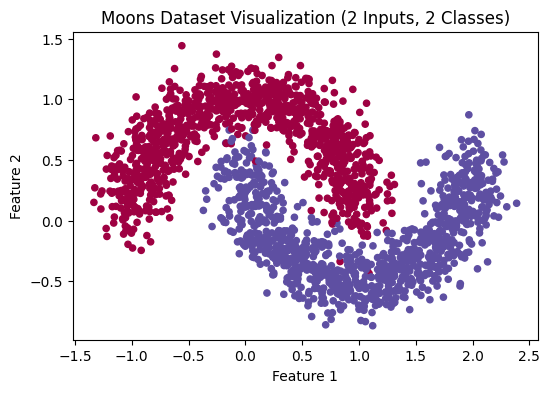

--- Stage 1/5: Training on chunk 1 (MLP) ---


| train_loss: 1.93e-05 | test_loss: 1.96e+00 | reg: 5.48e+01 | : 100%|█| 10/10 [00:00<00:00, 23.11it


  Accuracy on Chunk 1: 1.0000 (Trained)
  Accuracy on Chunk 2: 0.7375
  Accuracy on Chunk 3: 0.5219
  Accuracy on Chunk 4: 0.4563
  Accuracy on Chunk 5: 0.9969
  --> OVERALL ACCURACY: 0.7425
----------------------------------------


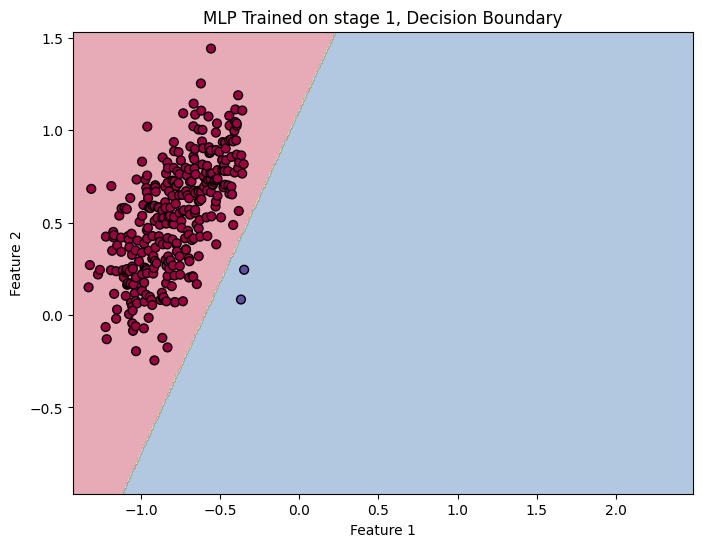

--- Stage 2/5: Training on chunk 2 (MLP) ---


| train_loss: 2.01e-01 | test_loss: 7.82e-01 | reg: 5.79e+01 | : 100%|█| 10/10 [00:00<00:00, 41.55it


  Accuracy on Chunk 1: 1.0000
  Accuracy on Chunk 2: 0.9812 (Trained)
  Accuracy on Chunk 3: 0.9438
  Accuracy on Chunk 4: 0.6781
  Accuracy on Chunk 5: 0.8188
  --> OVERALL ACCURACY: 0.8844
----------------------------------------


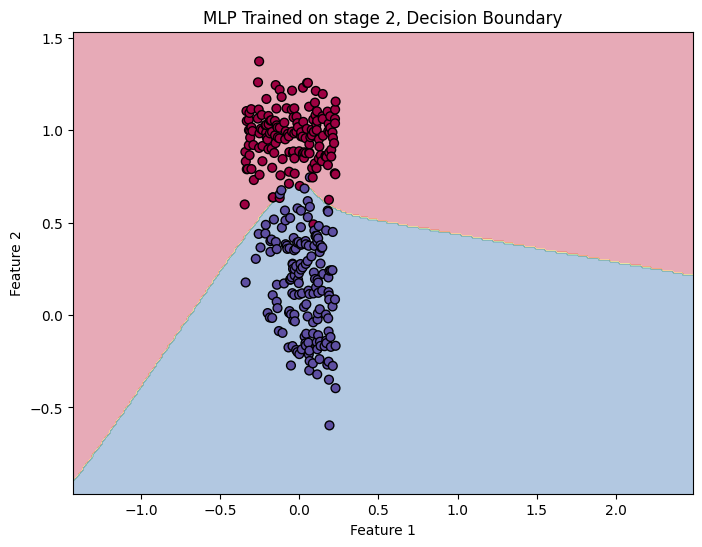

--- Stage 3/5: Training on chunk 3 (MLP) ---


| train_loss: 0.00e+00 | test_loss: 8.57e+00 | reg: 8.96e+01 | : 100%|█| 10/10 [00:00<00:00, 61.42it

  Accuracy on Chunk 1: 0.0094
  Accuracy on Chunk 2: 0.6938
  Accuracy on Chunk 3: 1.0000 (Trained)
  Accuracy on Chunk 4: 0.7250
  Accuracy on Chunk 5: 0.0031
  --> OVERALL ACCURACY: 0.4863
----------------------------------------


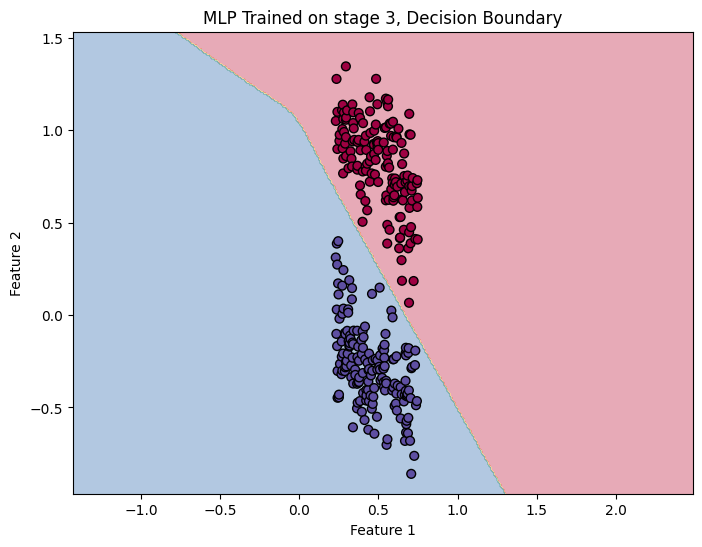

--- Stage 4/5: Training on chunk 4 (MLP) ---


| train_loss: 2.54e-01 | test_loss: 1.11e+00 | reg: 5.43e+01 | : 100%|█| 10/10 [00:00<00:00, 108.61i


  Accuracy on Chunk 1: 0.9937
  Accuracy on Chunk 2: 0.5094
  Accuracy on Chunk 3: 0.8219
  Accuracy on Chunk 4: 0.9812 (Trained)
  Accuracy on Chunk 5: 0.5875
  --> OVERALL ACCURACY: 0.7787
----------------------------------------


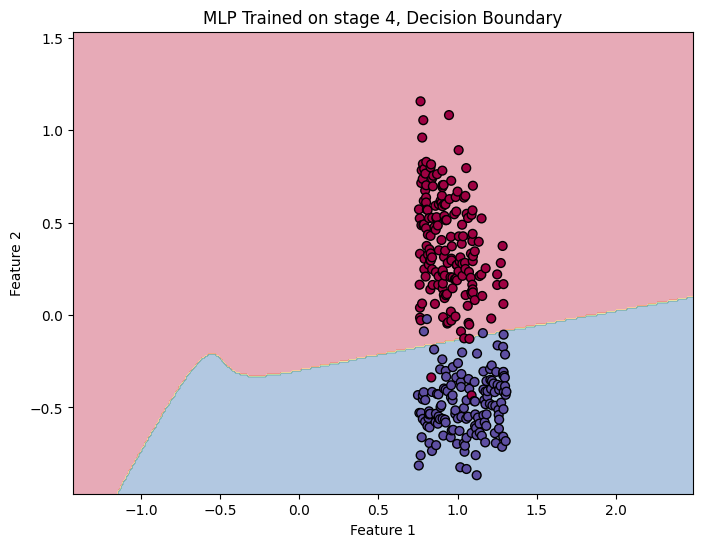

--- Stage 5/5: Training on chunk 5 (MLP) ---


| train_loss: 2.48e-04 | test_loss: 4.92e+00 | reg: 6.87e+02 | : 100%|█| 10/10 [00:00<00:00, 35.34it


  Accuracy on Chunk 1: 0.9937
  Accuracy on Chunk 2: 0.4906
  Accuracy on Chunk 3: 0.4781
  Accuracy on Chunk 4: 0.7750
  Accuracy on Chunk 5: 1.0000 (Trained)
  --> OVERALL ACCURACY: 0.7475
----------------------------------------


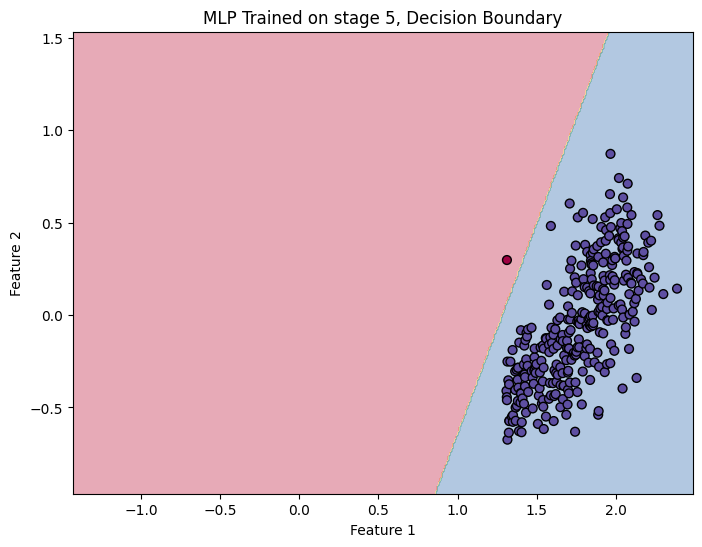

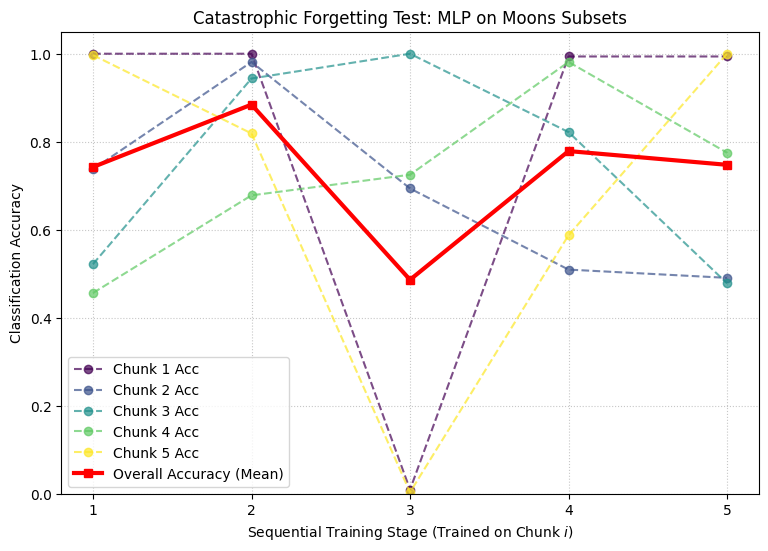

checkpoint directory created: ./model
saving model version 0.0
--- Stage 1/5: Training on chunk 1 (KAN) ---


| train_loss: 2.73e-05 | test_loss: 4.37e+00 | reg: 1.83e+02 | : 100%|█| 50/50 [00:02<00:00, 23.13it


saving model version 0.1
  Accuracy on Chunk 1: 1.0000 (Trained)
  Accuracy on Chunk 2: 0.4469
  Accuracy on Chunk 3: 0.4812
  Accuracy on Chunk 4: 0.5375
  Accuracy on Chunk 5: 0.0250
  --> OVERALL ACCURACY: 0.4981
----------------------------------------


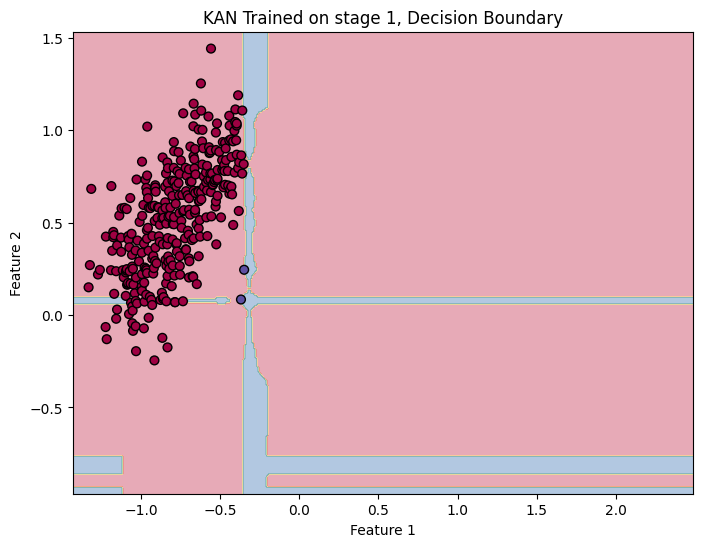

--- Stage 2/5: Training on chunk 2 (KAN) ---


| train_loss: 0.00e+00 | test_loss: 5.31e+00 | reg: 3.24e+02 | : 100%|█| 50/50 [00:02<00:00, 22.32it


saving model version 0.2
  Accuracy on Chunk 1: 0.3000
  Accuracy on Chunk 2: 1.0000 (Trained)
  Accuracy on Chunk 3: 0.7969
  Accuracy on Chunk 4: 0.4812
  Accuracy on Chunk 5: 0.9937
  --> OVERALL ACCURACY: 0.7144
----------------------------------------


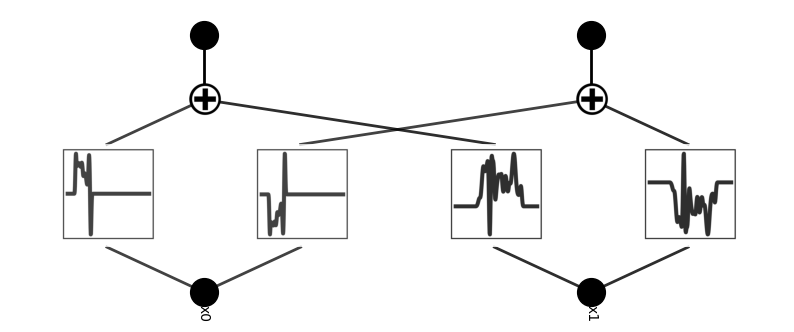

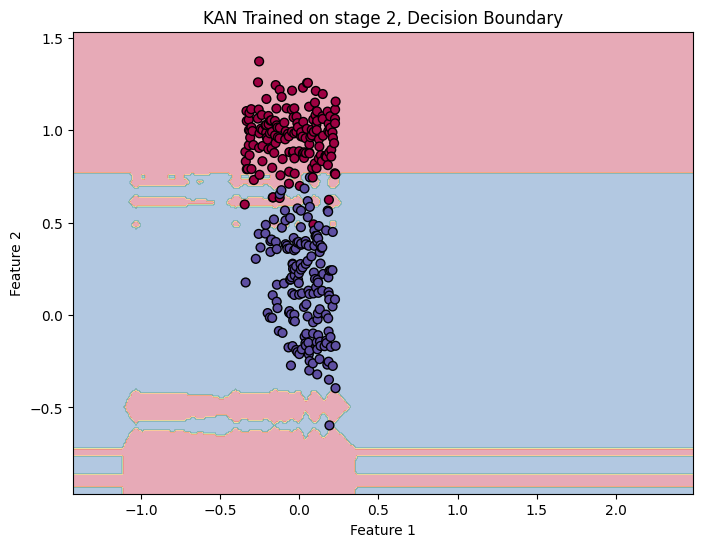

--- Stage 3/5: Training on chunk 3 (KAN) ---


| train_loss: 0.00e+00 | test_loss: 3.23e+00 | reg: 3.08e+02 | : 100%|█| 50/50 [00:02<00:00, 23.49it


saving model version 0.3
  Accuracy on Chunk 1: 0.7219
  Accuracy on Chunk 2: 0.7906
  Accuracy on Chunk 3: 1.0000 (Trained)
  Accuracy on Chunk 4: 0.6219
  Accuracy on Chunk 5: 0.9531
  --> OVERALL ACCURACY: 0.8175
----------------------------------------


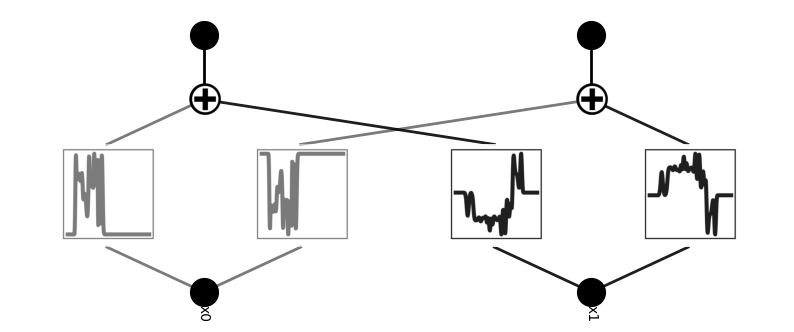

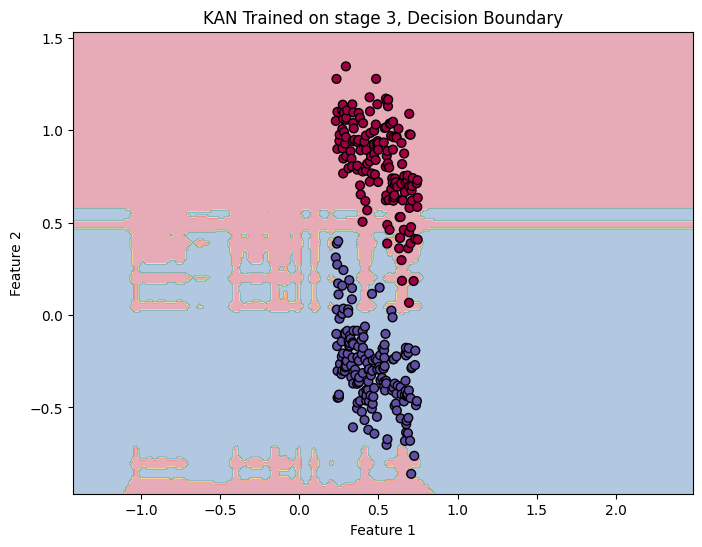

--- Stage 4/5: Training on chunk 4 (KAN) ---


| train_loss: 4.73e-05 | test_loss: 5.41e+00 | reg: 5.26e+02 | : 100%|█| 50/50 [00:02<00:00, 21.69it


saving model version 0.4
  Accuracy on Chunk 1: 0.9781
  Accuracy on Chunk 2: 0.5906
  Accuracy on Chunk 3: 0.8156
  Accuracy on Chunk 4: 1.0000 (Trained)
  Accuracy on Chunk 5: 0.5312
  --> OVERALL ACCURACY: 0.7831
----------------------------------------


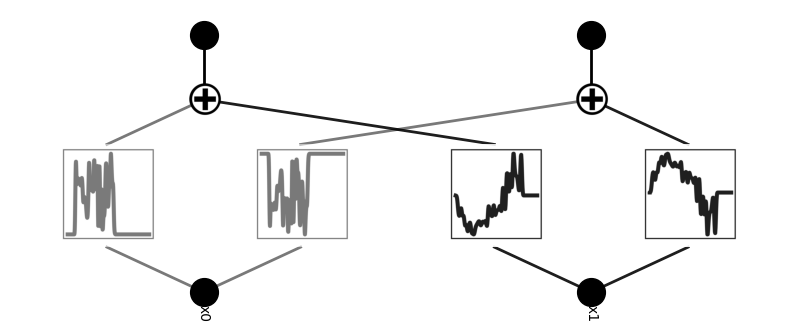

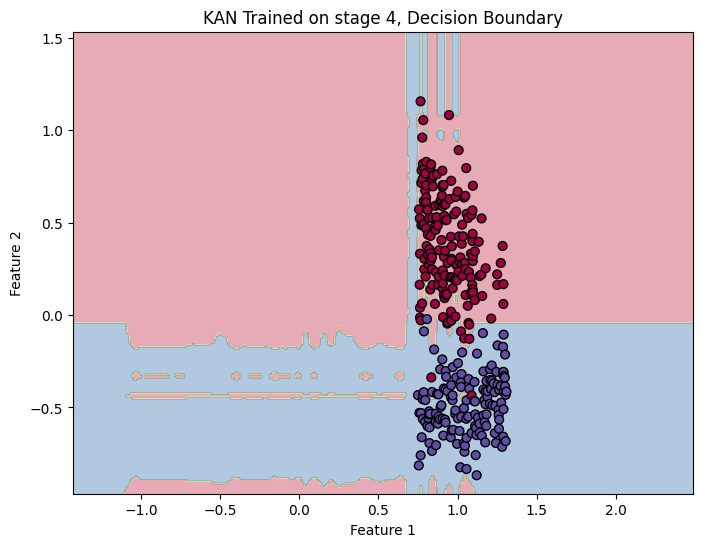

--- Stage 5/5: Training on chunk 5 (KAN) ---


| train_loss: 2.70e-04 | test_loss: 1.71e+01 | reg: 2.96e+03 | : 100%|█| 50/50 [00:01<00:00, 25.53it


saving model version 0.5
  Accuracy on Chunk 1: 0.3500
  Accuracy on Chunk 2: 0.9312
  Accuracy on Chunk 3: 0.8313
  Accuracy on Chunk 4: 0.5312
  Accuracy on Chunk 5: 1.0000 (Trained)
  --> OVERALL ACCURACY: 0.7287
----------------------------------------


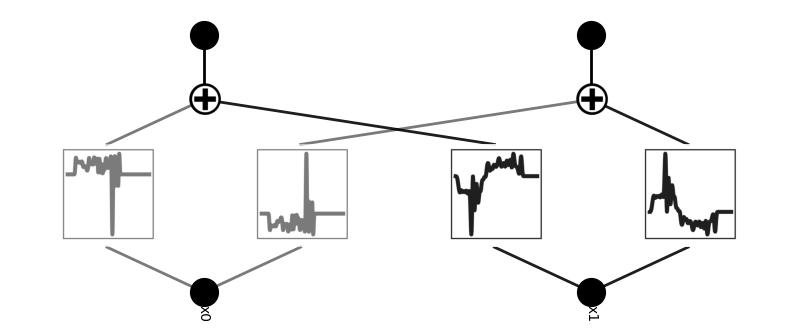

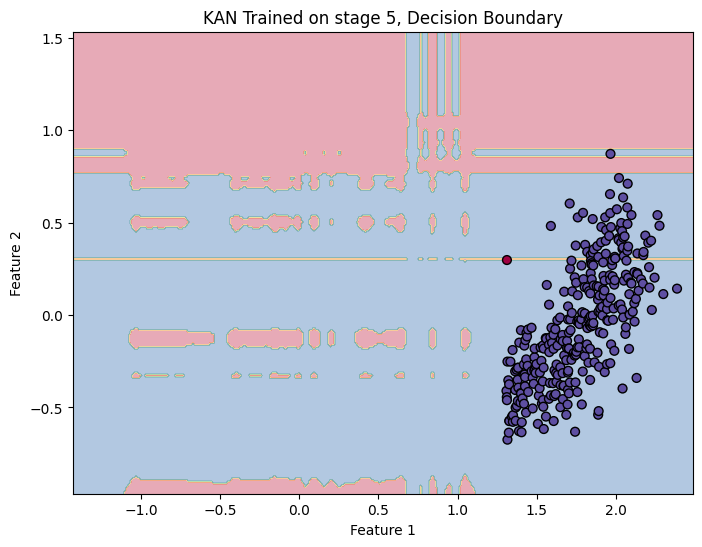

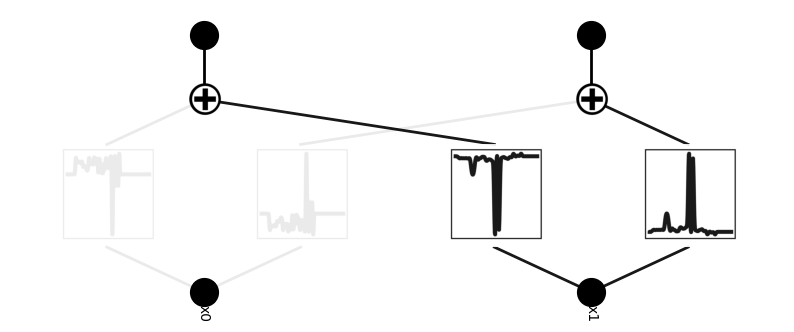

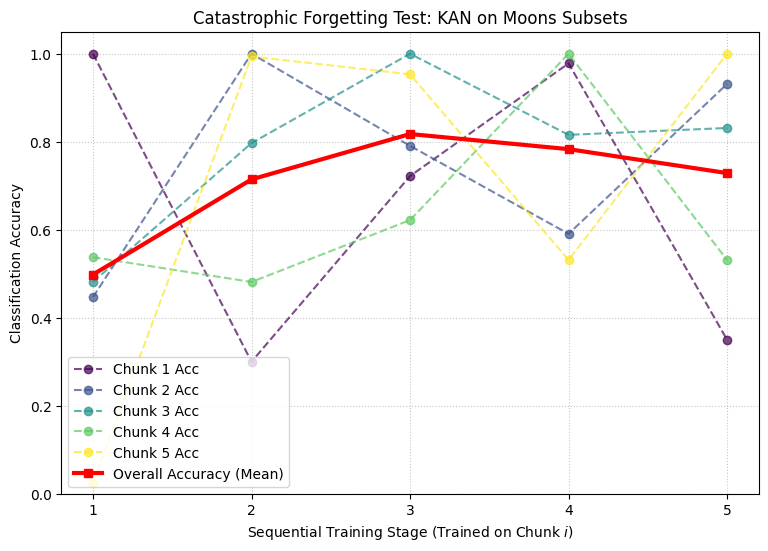

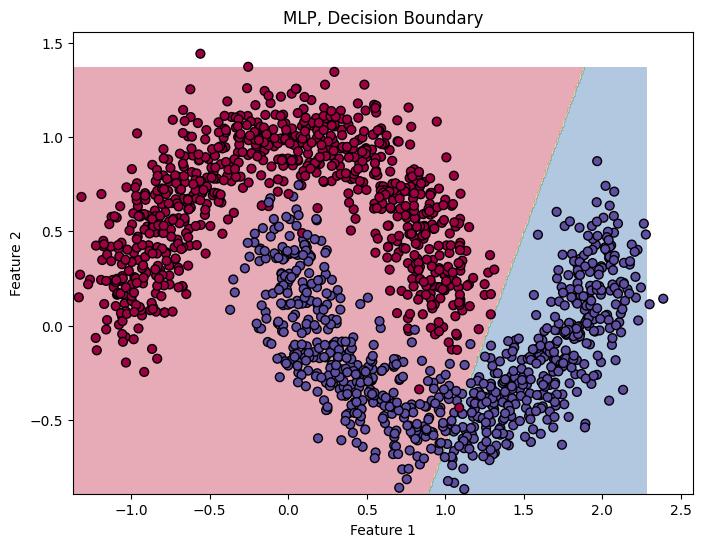

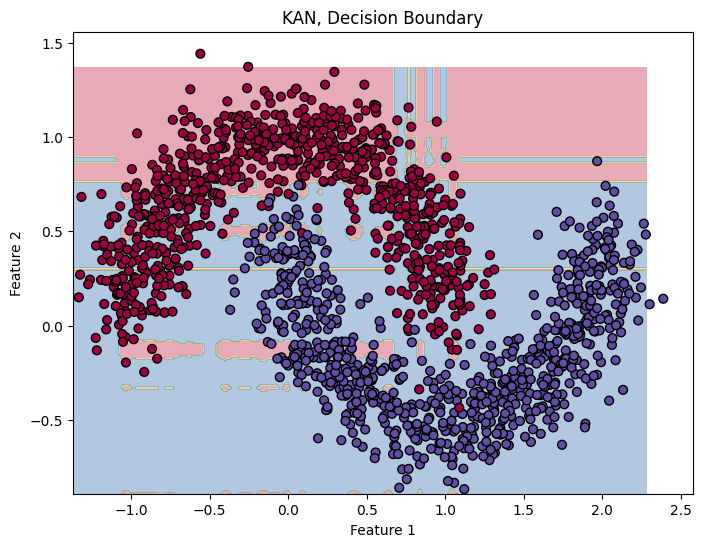

In [3]:
# ==========================================
#               MAIN EXECUTION
# ==========================================

dataset = get_moons_dataset(n_samples=2000, noise=0.15) # Increased samples/noise for a more complex test

X_train_full = dataset['train_input']
y_train_full = dataset['train_label']
full_train_dataset = {'train_input': X_train_full, 'train_label': y_train_full}

mlp_model, mlp_accs, mlp_overall_accs = test_catastrophic_forgetting_mlp(full_train_dataset, width=[2, 3, 2], n_stages=5, steps_per_stage=10, seed=42)

kan_model, kan_accs, kan_overall_accs = test_catastrophic_forgetting_kan(full_train_dataset, width=[2, 2], grid=50, k=3, n_stages=5, steps_per_stage=50, seed=42)


plot_decision_boundary(dataset, mlp_model, f"MLP")
plot_decision_boundary(dataset, kan_model, f"KAN")
